In [1]:
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-2.0-flash-001", temperature=1.0)

# Communicating through a shared list of messages

Again, we need first to download our dataset:

In [8]:
from datasets import load_dataset
ds = load_dataset("cais/mmlu", "high_school_geography")

i = 6
ds_dict = ds["test"].take(100).to_dict()
question = ds_dict["question"][i]
options = "\n".join([f"{i}. {a}" for i, a in enumerate(ds_dict["choices"][i])])

Let's create our research agent:

In [2]:
from langchain.agents import load_tools
from langgraph.prebuilt import create_react_agent


research_tools = load_tools(
  tool_names=["ddg-search", "arxiv", "wikipedia"],
  llm=llm
)

system_prompt = (
    "You're a hard-working, curious and creative student. "
    "You're working on exam quesion. Think step by step."
    "Always provide an argumentation for your answer. "
    "Do not assume anything, use available tools to search "
    "for evidence and supporting statements."
)

research_agent = create_react_agent(model=llm, tools=research_tools, prompt=system_prompt)

Now we need to define a reflection prompt:

In [9]:
reflection_prompt = (
    "You are a university professor and you're supervising a student who is "
    "working on multiple-choice exam question. "
    "Given the dialogue above, reflect on the answer provided and give a feedback "
    " if needed. If you think the final answer is correct, reply with "
    "an empty message. Only provide critique if you think the last answer might "
    "be incorrect or there are reasoning flaws. Do not assume anything, "
    "evaluate only the reasoning the student provided and whether there is "
    "enough evidence for their answer."
)


And let's put everything together to create our agent:

In [6]:
from langchain_core.prompts import PromptTemplate
from langgraph.types import Command
from langchain_core.runnables import RunnableConfig


question_template = PromptTemplate.from_template(
    "QUESTION:\n{question}\n\nANSWER OPTIONS:\n{options}\n\n"
)

def _ask_question(state):
  return {"messages": [("human", question_template.invoke(state).text)]}

def _give_feedback(state, config: RunnableConfig):
  messages = event["messages"] + [("human", reflection_prompt)]
  max_messages = config["configurable"].get("max_messages", 20)

  if len(messages) > max_messages:
    return Command(
      update={},
      goto=END
    )

  result = llm.invoke(messages)

  if result.content:
    return Command(
      update={"messages": [
          ("assistant", result.content),
           ("human", "Please, address the feedback above and give an answer.")]},
      goto="research"
  )
  return Command(
      update={},
      goto=END
  )

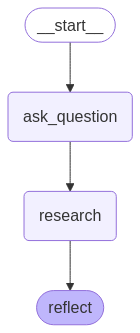

In [7]:
from langgraph.graph import StateGraph, START, END, MessagesState

class ReflectionAgentState(MessagesState):
  question: str
  options: str

builder = StateGraph(ReflectionAgentState)
builder.add_node("ask_question", _ask_question)
builder.add_node("research", research_agent)
builder.add_node("reflect", _give_feedback)

builder.add_edge(START, "ask_question")
builder.add_edge("ask_question", "research")
builder.add_edge("research", "reflect")
graph = builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Now if we run our agent, we can see how amount of messages is increasing on each turn:

In [11]:
async for _, event in graph.astream({"question": question, "options": options}, stream_mode=["values"]):
  print(len(event["messages"]))

0
1


7
9


15
17
18
20
21


In [12]:
for m in event["messages"]:
  print(type(m))

<class 'langchain_core.messages.human.HumanMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.human.HumanMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.human.HumanMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.human.HumanMessage'>
<cla

We can also explore the conversation between our specialized agents:

In [13]:
for m in event["messages"]:
  m.pretty_print()

================================ Human Message =================================

QUESTION:
Which of the following countries does NOT have a well-known example of a relict boundary?

ANSWER OPTIONS:
0. Vietnam
1. United Kingdom
2. Germany
3. Bolivia


================================== Ai Message ==================================

A relict boundary is a former boundary line that no longer functions as an international border but is still marked by some landscape feature or cultural division. To determine which of the listed countries does NOT have a well-known example of a relict boundary, I will investigate each country individually.

*   **Vietnam:** I will search for "relict boundary Vietnam" to see if there are any well-known examples.
*   **United Kingdom:** I will search for "relict boundary United Kingdom" to see if there are any well-known examples.
*   **Germany:** I will search for "relict boundary Germany" to see if there are any well-known examples.
*   **Bolivia:** I will